# Hero Run for Training Simple Feed Forward Ensamble

So not sure how mpi will be calling the models, but potentially x72 models. I wanted to have an ensamble of 3 models to calc the average output. So need x216 models, at 200 MB is 43.2 GB. Further investigation is needed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torch.amp import autocast
from torch.amp import GradScaler

import h5py as h5

import matplotlib.pyplot as plt

from os.path import join

We are going to do hybrid heterogenious computing, so assert GPU is available

In [2]:
assert torch.cuda.is_available(), 'CUDA is not available.'
device = torch.device('cuda')
dtype = torch.float64

## Simple FF Model

Simple FF net. Flatten input so $(3*2*2 + 70*2*2*2)=852$. And flatten output $(70*2*2*2)=560$.
Also use float32 to minimize size (can move to float64 later), CESM will output float64 so will need to handle inside the ensamble

In [3]:
class simpleNN(nn.Module):
    def __init__(self):
        super(simpleNN, self).__init__()
        self.fc1 = nn.Linear(852,4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 560)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Data Loading

Data was pre partitioned into training and test dataset

In [4]:
train_name = join('/home/squirt/Documents/data/weather_data/', 'train_data.h5')
test_name = join('/home/squirt/Documents/data/weather_data/', 'test_data.h5')

Method to load hdf5 file of the processed weather data

In [5]:
def load_hdf5(filename:str):
    '''
    Load data from an HDF5 file and return a list of dictionaries.
    Inputs:
        - filename (str): Path to the HDF5 file.
    Outputs:
        - data (list): List of dictionaries, where each dictionary represents an entry in the original list.
    '''
    data = []  # List to hold dictionaries
    with h5.File(filename, 'r') as f:
        # Iterate through groups (each representing an entry in the original list)
        for group_name in f:
            group = f[group_name]
            # Reconstruct dictionary from datasets and attributes
            entry = {
                # Attributes (metadata)
                'day': group.attrs['day'],
                'region': group.attrs['region'],
                'time': group.attrs['time'],

                # groups (numpy arrays)
                'landmass': group['landmass'][...],  # Use [...] to read the full dataset
                'x': group['x'][...],
                'y': group['y'][...],
            }
            data.append(entry)
    return data

Generate stacks to train

In [6]:
def stack_data(data:list[dict], key:str) -> torch.Tensor:
    return torch.stack([torch.tensor(entry[key]) for entry in data])


def generate_stacks(data:list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''
    Create a PyTorch DataLoader from the data.
    Inputs:
        - data (list): List of dictionaries, where each dictionary represents an entry in the original list.
    Outputs:
        - landmass (torch.Tensor): Tensor of landmass data.
        - x (torch.Tensor): Tensor of x-coordinate data.
        - y (torch.Tensor): Tensor of y-coordinate data.
    '''
    landmass = stack_data(data, 'landmass')

    x = stack_data(data, 'x')
    x = x.transpose(2, 1)

    y = stack_data(data, 'y')
    y = y.transpose(2, 1)
    
    return (landmass, x, y)


class weather_dataset(Dataset):
    '''
    PyTorch Dataset class for weather data.
    '''
    def __init__(self, data:list[dict]):
        self.landmass, self.x, self.y = generate_stacks(data)
        self.length = len(self.landmass)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return (self.landmass[idx], self.x[idx], self.y[idx])

Partition training data into train and validation sets.

In [7]:
def get_dataloaders(fname:str, batch_size:int, split:int) -> tuple[DataLoader, DataLoader]:
    '''
    Create PyTorch DataLoader objects for training and validation data.
    Inputs:
        - fname (str): Path to the HDF5 file.
        - batch_size (int): Batch size for the DataLoader objects.
        - split (float): Fraction of the data to use for training.     
    Outputs:
        - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        - test_loader (torch.utils.data.DataLoader): DataLoader for test data.
    '''
    # Load data and create tensor 
    data = load_hdf5(fname)
    dataset = weather_dataset(data)
    
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split data into training and validation sets
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create DataLoader objects
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    return train_loader, test_loader

Only Normalize the x/y data, not the landmass, on train_loader.dataset.*

## Model Block

Want to have normalization layer (x) -> reshape -> NN -> reshape - > denorm layer (y). 

In [8]:
class NormalizationLayer(nn.Module):
    def __init__(self, data: torch.Tensor):
        super(NormalizationLayer, self).__init__()

        # Compute mean and std along the batch_size, x1, and x2 dimensions
        self.mean = data.mean(dim=(0, 3, 4), keepdim=True).to(device, dtype=dtype) 
        self.std = data.std(dim=(0, 3, 4), keepdim=True).to(device, dtype=dtype) 

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Normalize the data
        normalized_data = (x - self.mean) / (self.std + 1e-9)  # Add a small constant to avoid division by zero
        return normalized_data

In [9]:
class DenormalizationLayer(nn.Module):
    def __init__(self, data: torch.Tensor):
        super(DenormalizationLayer, self).__init__()

        # Compute mean and std along the batch_size, x1, and x2 dimensions
        self.mean = data.mean(dim=(0, 3, 4), keepdim=True).to(device, dtype=dtype)  
        self.std = data.std(dim=(0, 3, 4), keepdim=True).to(device, dtype=dtype) 

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Denormalize the data
        denormalized_data = x * (self.std + 1e-9) + self.mean
        return denormalized_data

In [10]:
class ReshapeLayer(nn.Module):
    def __init__(self, l_shape: tuple = (-1, 3*2*2), x_shape: tuple = (-1, 70*3*2*2), y_shape: tuple = (-1, 70,2,2,2)):
        super(ReshapeLayer, self).__init__()
        self.l_shape = l_shape
        self.x_shape = x_shape
        self.y_shape = y_shape

    def reshape_x(self, l: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        l = l.view(self.l_shape)
        x = x.view(self.x_shape)
        x = torch.cat((l, x), 1)
        return x

    def reshape_y(self, y: torch.Tensor) -> torch.Tensor:
        y = y.view(self.y_shape)
        return y

In [11]:
class CompleteModel(nn.Module):
    def __init__(self, norm_layer:NormalizationLayer, reshape_layer:ReshapeLayer, neural_network:simpleNN, denorm_layer:DenormalizationLayer):
        super(CompleteModel, self).__init__()
        self.norm_layer = norm_layer
        self.reshape_layer = reshape_layer 
        self.neural_network = neural_network
        self.denorm_layer = denorm_layer

    def forward(self, x:torch.Tensor, l:torch.Tensor) -> torch.Tensor:
        x = self.norm_layer(x)
        x = self.reshape_layer.reshape_x(l, x)

        x = self.neural_network(x)
        x = self.reshape_layer.reshape_y(x)  # reshape back to original shape
        x = self.denorm_layer(x)
        return x

Only Norm/Denorm x and y

In [12]:
def make_model(loader) -> CompleteModel:
    norm_layer = NormalizationLayer(loader.dataset.dataset.x)
    denorm_layer = DenormalizationLayer(loader.dataset.dataset.y)
    reshape_layer = ReshapeLayer().to(device, dtype=dtype) 

    model = simpleNN().to(device, dtype=dtype) 

    network = CompleteModel(norm_layer, reshape_layer, model, denorm_layer).to(device, dtype=dtype) 
    return network

## Training Loop 

Define training loop, use mixed percision training

In [13]:
def train(model:nn.Module, dl:torch.utils.data.DataLoader, optim:torch.optim, loss:nn.Module) -> float:
    model.train()
    total_loss = .0
    scaler = GradScaler()

    for _, (l, x, y) in enumerate(dl):
        l = l.to(device, dtype=dtype) 
        x = x.to(device, dtype=dtype) 
        y = y.to(device, dtype=dtype) 

        optim.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            y_pred = model(x, l)
            l = loss(y_pred, y)
            total_loss += l.item()

        # Preform backpass
        scaler.scale(l).backward()
        scaler.step(optim)
        scaler.update()
    
    return total_loss / len(dl)

Eval Loop

In [14]:
def eval(model:nn.Module, dl:torch.utils.data.DataLoader, loss:nn.Module) -> float:
    model.eval()
    total_loss = .0

    for _, (l, x, y) in enumerate(dl):
        l = l.to(device, dtype=dtype) 
        x = x.to(device, dtype=dtype) 
        y = y.to(device, dtype=dtype)

        # Forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            y_pred = model(x, l)
            l = loss(y_pred, y)
            total_loss += l.item()

    return total_loss / len(dl)

## Training

In [15]:
folds = 5 
models = {}

test_ds = weather_dataset(load_hdf5(test_name)) 
test_loader = DataLoader(test_ds, batch_size=4096, shuffle=True, num_workers=8, pin_memory=True)

for i in range(folds):
    train_loader, val_loader = get_dataloaders(train_name, 4096, 0.6)

    loss_fn = nn.MSELoss()
    model = make_model(train_loader) 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early Stopping 
    eval_loss = -1*float('inf') 
    train_loss  = float('inf') 
    j = 0
    print(f'Fold {i+1}')
    while train_loss > eval_loss:
        prev_eval_loss = eval_loss
        train_loss = train(model, train_loader, optimizer, loss_fn)
        eval_loss = eval(model, val_loader, loss_fn)
        print(f'\tEpoch {j} - Eval Loss: {eval_loss}')
        
        if abs(eval_loss - prev_eval_loss) < 0.01:
            print(f'\tEarly stopping at epoch {j} due to minimal change in eval loss')
            break
        j += 1

    # Test Loss
    test_loss = eval(model, test_loader, loss_fn)
    print(f'Fold {i+1} - Test Loss: {test_loss}')

    # Save Model
    model.eval()
    models[i] = model


Fold 1
	Epoch 0 - Eval Loss: 23.236799495491077
	Epoch 1 - Eval Loss: 23.698907277915232
	Epoch 2 - Eval Loss: 4.302717865197733
	Epoch 3 - Eval Loss: 1.1378947618079245
	Epoch 4 - Eval Loss: 0.7583604163926001
	Epoch 5 - Eval Loss: 0.532789637998007
	Epoch 6 - Eval Loss: 0.3903434571691541
	Epoch 7 - Eval Loss: 0.3426517185550847
	Epoch 8 - Eval Loss: 0.2529520811252329
	Epoch 9 - Eval Loss: 0.21465006955289195
	Epoch 10 - Eval Loss: 0.18761744539512853
	Epoch 11 - Eval Loss: 0.18422442462912308
	Early stopping at epoch 11 due to minimal change in eval loss
Fold 1 - Test Loss: 0.18841547844618364
Fold 2
	Epoch 0 - Eval Loss: 25.76154177411202
	Epoch 1 - Eval Loss: 22.607960865196368
	Epoch 2 - Eval Loss: 4.574869696614085
	Epoch 3 - Eval Loss: 1.1335826108536424
	Epoch 4 - Eval Loss: 0.6621237201071495
	Epoch 5 - Eval Loss: 0.4365433632372601
	Epoch 6 - Eval Loss: 0.28620379351230785
	Epoch 7 - Eval Loss: 0.2630671623712332
	Epoch 8 - Eval Loss: 0.22614827135782595
	Epoch 9 - Eval Los

## Plotting

In [16]:
def get_cell_data(t:torch.tensor) -> torch.tensor:
    t = t.view(-1, 70, 2, 2, 2)
    # T and QV are the 2 STD channels with a 2x2 grid
    # We want to get the top left cell for both channels
    p = t[:,:,:,0,0]
    p = p.view(-1, 70, 2)
    return p

In [17]:
def plot_column(data_dict:dict, idx:int):
    if idx not in {0,1}:
        raise ValueError('idx must be 0 or 1')
    title = 'Temp' if idx == 0 else 'QV'

    # Get the data for the 1st column (were just trying to determin if we want to park model for now)
    data = []
    for _,v in data_dict.items():
        data.append(v[0][0,:,idx])

    #print(data[0][:,0])
    data = torch.stack(data)
    #print(data[0,:,0])

    # Calculate Mean and STD
    mean = (data.mean(dim=0)).cpu().numpy()
    std = (data.std(dim=0)).cpu().numpy()

    # Get Real Values
    real = (data_dict[0][1][0,:,idx]).cpu().numpy()

    # Plot
    # Plotting
    plt.figure(figsize=(10, 6))
    x = range(len(mean))
            
    plt.plot(x, real, label='True Value', color='blue', linestyle='None', marker='o')
    plt.plot(x, mean, label='Mean Prediction', color='red', linestyle='--')
    plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2, label='Prediction Std Dev')

    plt.title(f'{title} Predictions vs True Values')
    plt.xlabel('Cell')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
batch_data = next(iter(test_loader))
l, x, y = batch_data
l = l.cuda()
x = x.cuda()
y = y.cuda()

In [19]:
model_preds = {}
for i, model in models.items():
    with torch.no_grad():
        y_hat = model(x, l)
        model_preds[i] = (y_hat, y)

In [20]:
plot_values = {}
for k,v in model_preds.items():
    plot_values[k] = (get_cell_data(v[0]), get_cell_data(v[1]))

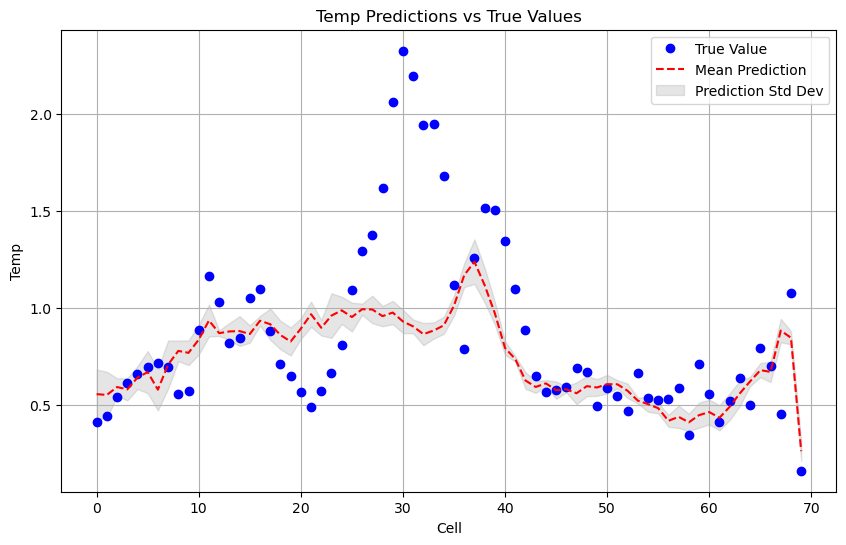

In [21]:
plot_column(plot_values, 0)

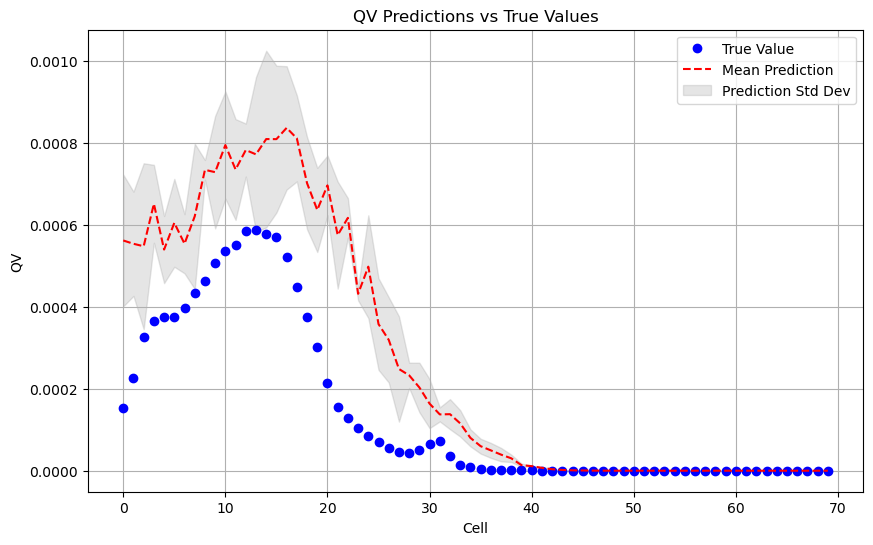

In [22]:
plot_column(plot_values, 1)

## Save Model

In [23]:
for i,m in models.items():
    try:
        script_model = torch.jit.script(m)
        script_model.save(f"./weights/simple_net_{i}.pt")
        print(f"Model {i} saved successfully.")
    except Exception as e:
        print(f"Error saving model {i}: {e}")

Model 0 saved successfully.
Model 1 saved successfully.
Model 2 saved successfully.
Model 3 saved successfully.
Model 4 saved successfully.
